In [1]:
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from matplotlib import pyplot as plt


/opt/conda/envs/ldm2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')

In [3]:
model_id_or_path = "CompVis/stable-diffusion-v1-4"
scheduler = DDIMScheduler.from_config(model_id_or_path, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(
    model_id_or_path,
    safety_checker=None,
    use_auth_token=True,
    scheduler = scheduler,
).to(device)

Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 22550.02it/s]
You have passed `None` for safety_checker to disable its functionality in <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'>. Note that this might lead to problems when using <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> and is not recommended.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please hav

In [101]:
img_prompts = [
    "A girl sitting in a field",
    "Two birds sitting on a branch.",
    "A basket with apples on a chair.",
    "A bicycle is parking on the side of the street",
    "A child is climbing on a tree",
    "A Landscape of mountains",
    "close up of a giraffe eating a bucket",
    "A woman with a blue hair.",
    "a black dinning room table sitting in a yellow dinning room.",
    "Two people riding elephants in dirty deep water.",
    "A man in glasses eating a doughnut in the park",
    "A cake on a table",
    "A piece of cake",
]


In [80]:
img_urls = [
    "https://images.unsplash.com/photo-1523177567729-8771749914c9?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=3087&q=80",
    "https://cdn.pixabay.com/photo/2018/05/27/18/19/sparrows-3434123_1280.jpg",
    "https://images.unsplash.com/photo-1613061527119-56ad37b8a581?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=3088&q=80",
    "https://images.unsplash.com/photo-1618762044398-ec1e7e048bbd?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=3027&q=80",
    "https://images.unsplash.com/flagged/photo-1569372874713-7216edf25e70?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2970&q=80",
    "https://cdn.pixabay.com/photo/2020/02/12/10/12/desert-4842264_1280.jpg",
    "https://live.staticflickr.com/1878/30850708538_58d8c3a50c_c_d.jpg",
    "https://images.unsplash.com/photo-1508272954429-7ebca1d1b8d7?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=3087&q=80",
    "http://farm4.staticflickr.com/3228/2302486401_72814f50ff_z.jpg",
    "https://farm9.staticflickr.com/8197/8176997270_6376e627b5_z.jpg",
    "https://farm5.staticflickr.com/4070/4671299015_b459f75463_z.jpg",
    "https://farm7.staticflickr.com/6114/6336601581_f53b8b1e86_z.jpg",
    "https://farm9.staticflickr.com/8020/7362895754_da6b89435b_z.jpg"
]


In [84]:
img_idx = 11

In [85]:

url = img_urls[img_idx]
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")
image = image.resize((512, 512))
# init_image

In [86]:
def preprocess_image(image):
    image = np.array(image.convert("RGB"))
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0
    return image

In [87]:
pp_image = preprocess_image(image)

In [88]:
generator = torch.Generator(device=device)
latent = pipe.vae.encode(pp_image.to(device)).latent_dist.sample(generator=generator) *  0.18215

In [91]:
prompt =img_prompts[img_idx]
text_embeddings = pipe._encode_prompt(prompt, device, 1, False, None)

## DDIM Inversion

In [121]:
@torch.no_grad()
def ddim_inversion(latents, encoder_hidden_states, noise_scheduler, unet):
    next_latents = latents
    all_latents = [latents.detach().cpu()]

    for timestep, next_timestep in zip(reversed(noise_scheduler.timesteps[1:]), reversed(noise_scheduler.timesteps[:-1])):
        latent_model_input = noise_scheduler.scale_model_input(next_latents, timestep)
        noise_pred = unet(latent_model_input, timestep, encoder_hidden_states).sample

        alpha_prod_t =  noise_scheduler.alphas_cumprod[timestep]
        alpha_prod_t_next = noise_scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_next = 1 - alpha_prod_t_next

        f = (next_latents - beta_prod_t ** 0.5 * noise_pred) / (alpha_prod_t ** 0.5)
        next_latents = alpha_prod_t_next ** 0.5 * f + beta_prod_t_next ** 0.5 * noise_pred
        all_latents.append(next_latents.detach().cpu())


    return all_latents

In [92]:
num_inference_steps = 50
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
all_latents = ddim_inversion(latent, text_embeddings, pipe.scheduler, pipe.unet)

In [93]:
z_T = all_latents[-1].to(device)
im = pipe(prompt=prompt, latents=z_T, generator=generator)

100%|██████████| 50/50 [00:05<00:00,  8.98it/s]


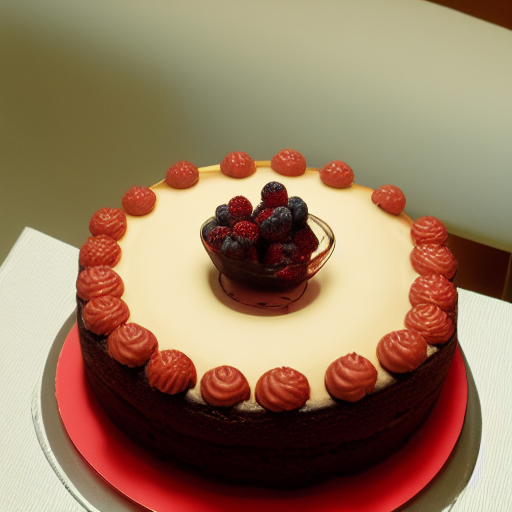

In [67]:
im[0][0]

## Null-text Inversion

In [95]:
def null_text_inversion(
    pipe,
    all_latents,
    prompt,
    num_opt_steps=10,
    lr=0.01,
    tol=1e-5,
    guidance_scale=7.5,
    eta: float = 0.0,
    generator = None
):
    # get null text embeddings for prompt
    null_text_prompt = ""
    null_text_input = pipe.tokenizer(
        null_text_prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncaton=True,
        return_tensors="pt",
    )
    null_text_embeddings = torch.nn.Parameter(pipe.text_encoder(null_text_input.input_ids.to(pipe.device))[0], requires_grad=True)
    null_text_embeddings = null_text_embeddings.detach()
    null_text_embeddings.requires_grad_(True)

    # Initialize the optimizer
    optimizer = torch.optim.Adam(
        [null_text_embeddings],  # only optimize the embeddings
        lr=lr,
    )

    # step_ratio = pipe.scheduler.config.num_train_timesteps // pipe.scheduler.num_inference_steps
    text_embeddings = pipe._encode_prompt(prompt, device, 1, False, None).detach()
    # input_embeddings = torch.cat([null_text_embeddings, text_embeddings], dim=0)
    extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
    all_null_texts = []
    latents = all_latents[-1]
    latents = latents.to(pipe.device)
    for timestep, prev_latents in pipe.progress_bar(zip(pipe.scheduler.timesteps, reversed(all_latents[:-1]))):
        prev_latents = prev_latents.to(pipe.device).detach()
        
        # expand the latents if we are doing classifier free guidance
        latent_model_input = pipe.scheduler.scale_model_input(latents, timestep).detach()
        noise_pred_text = pipe.unet(latent_model_input, timestep, encoder_hidden_states=text_embeddings).sample.detach()
        for _ in range(num_opt_steps):
            # predict the noise residual
            noise_pred_uncond = pipe.unet(latent_model_input, timestep, encoder_hidden_states=null_text_embeddings).sample

            # perform guidance
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            prev_latents_pred = pipe.scheduler.step(noise_pred, timestep, latents, **extra_step_kwargs).prev_sample
            loss = torch.nn.functional.mse_loss(prev_latents_pred, prev_latents).mean()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        all_null_texts.append(null_text_embeddings.detach().cpu())
        latents = prev_latents_pred.detach()
    return all_latents[-1], all_null_texts

In [96]:
z_T, all_null_texts = null_text_inversion(pipe, all_latents, prompt, num_opt_steps=20)

Keyword arguments {'truncaton': True} not recognized.
49it [03:41,  4.51s/it]


In [97]:
@torch.no_grad()
def reconstruct(pipe, latents, prompt, null_text_embeddings, guidance_scale=7.5, generator=None, eta=0.0):
    text_embeddings = pipe._encode_prompt(prompt, device, 1, False, None)
    extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
    latents = latents.to(pipe.device)
    for i, (t, null_text_t) in enumerate(pipe.progress_bar(zip(pipe.scheduler.timesteps, null_text_embeddings))):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        input_embedding = torch.cat([null_text_t.to(pipe.device), text_embeddings])
        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=input_embedding).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

    #Post-processing
    image = pipe.decode_latents(latents)
    return image

In [98]:
recon_img = reconstruct(pipe, z_T, prompt, all_null_texts)

49it [00:05,  8.96it/s]


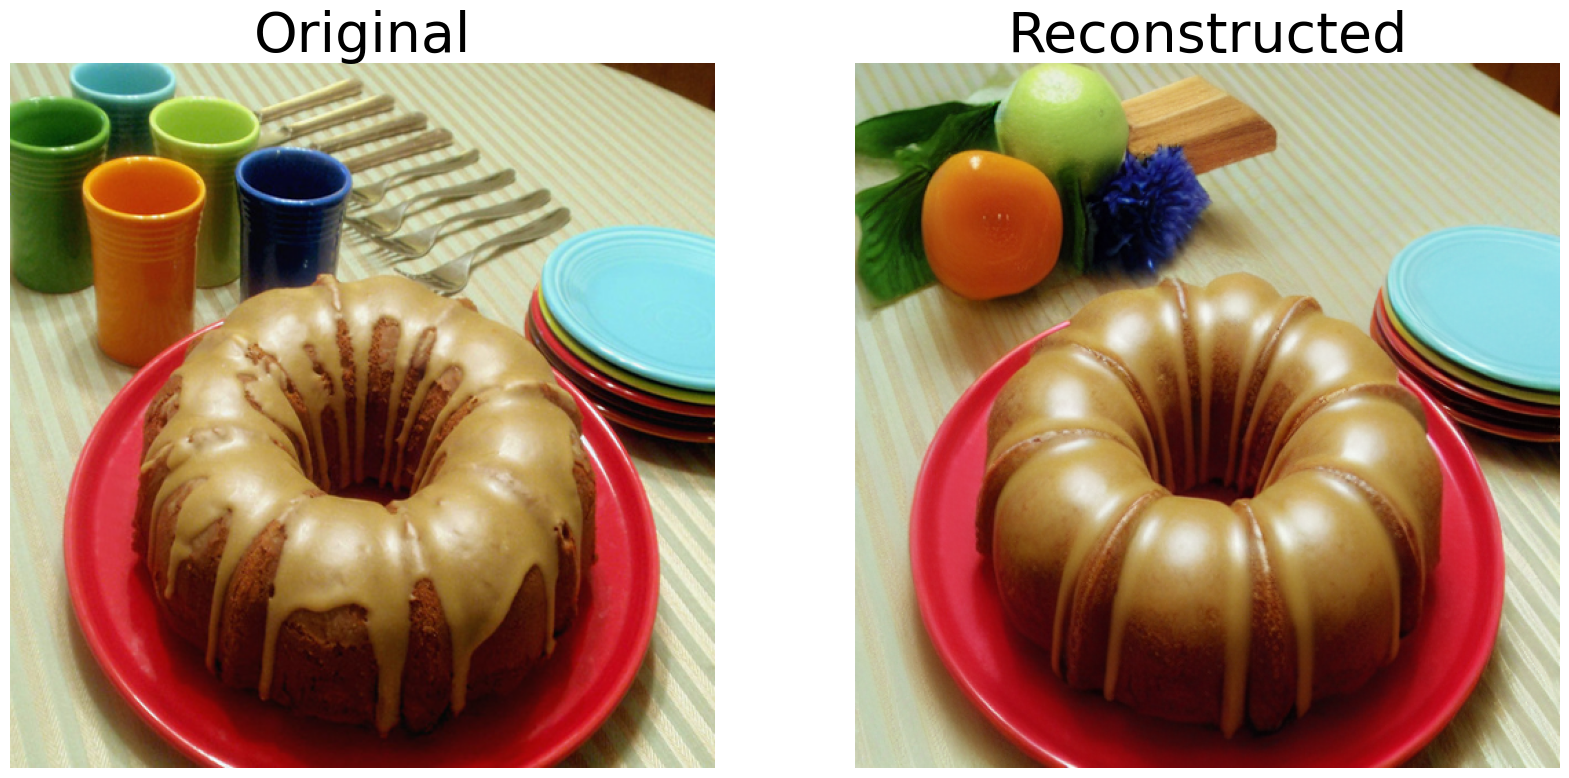

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(pp_image[0].permute(1,2,0).numpy() * 0.5 + 0.5)
ax[0].set_title("Original", fontdict={'fontsize': 40})
ax[0].axis('off')

ax[1].imshow(recon_img[0])
ax[1].set_title("Reconstructed", fontdict={'fontsize': 40})
ax[1].axis('off')

plt.show()

## Editing the Inverted image

In [133]:
edit_prompt = "A chocolate cake on a table"
edit_imgs = []
num_imgs = 8
for scale in np.linspace(1.5, 7.5, num_imgs):
    edit_img = reconstruct(pipe, z_T, edit_prompt, all_null_texts, guidance_scale=scale)
    edit_imgs.append(edit_img)

49it [00:05,  8.90it/s]
49it [00:05,  8.92it/s]
49it [00:05,  8.93it/s]
49it [00:05,  8.93it/s]
49it [00:05,  8.91it/s]
49it [00:05,  8.93it/s]
49it [00:05,  8.93it/s]
49it [00:05,  8.95it/s]


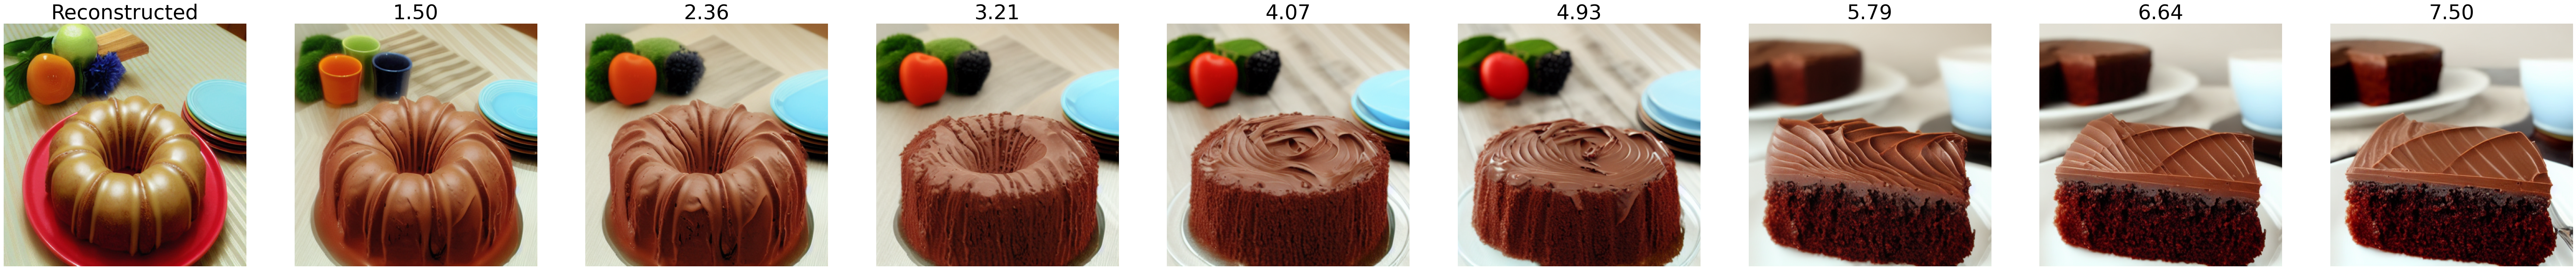

In [120]:
fig, ax = plt.subplots(1, num_imgs + 1, figsize=(10 * (num_imgs+1), 10))

ax[0].imshow(recon_img[0])
ax[0].set_title("Reconstructed", fontdict={'fontsize': 40})
ax[0].axis('off')

for i, scale in enumerate(np.linspace(1.5, 7.5, num_imgs)):
    ax[i+1].imshow(edit_imgs[i][0])
    ax[i+1].set_title("%.2f"%scale, fontdict={'fontsize': 40})
    ax[i+1].axis('off')
plt.show()